In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import sys

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
from os import path
import tqdm.notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import torch
import joblib
import numpy as np

sys.path.append('/home/ivan/Рабочий стол/vtb-matching/')
tqdm_notebook.pandas()

In [3]:
data_dir = '/home/ivan/Рабочий стол/vtb-matching/data'

In [4]:
# Расшифровка MCC кодов транзакций
mcc_codes = pd.read_csv(path.join(data_dir, 'mcc_codes.csv'))
# Расшифровка кодов категорий кликстрима
click_categories = pd.read_csv(path.join(data_dir, 'click_categories.csv'))
# Кликстрим
clickstream = pd.read_csv(path.join(data_dir, 'clickstream.csv'))
# Расшифровка кодов валют
currency_rk = pd.read_csv(path.join(data_dir, 'currency_rk.csv'))
# Целевая переменная — табличный файл с точным соответствием между id клиентов 
# в данных транзакций и кликстримов. Разметка представлена не для всех клиентов, 
# присутствующих в данных транзакций и кликстрима
train_matching = pd.read_csv(path.join(data_dir, 'train_matching.csv'))
# Список транзакций
transactions = pd.read_csv(path.join(data_dir, 'transactions.csv'))

In [5]:
mcc_codes.head()

,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."
2,780,Услуги садоводства и ландшафтного дизайна,Ландшафтные архитекторы и другие поставщики ус...
3,1520,Генеральные подрядчики – жилое и коммерческое ...,"Генеральные подрядчики, в основном занимающиес..."
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Специальные торговые подрядчики, которые работ..."


In [6]:
click_categories.head()

,cat_id,level_0,level_1,level_2
0,1,accessories,NaN,NaN
1,2,accessories,handbags,NaN
2,3,accessories,jewellery,NaN
3,8,accessories,watches,NaN
4,11,age,age_0-5_yo,NaN


In [7]:
clickstream.head()

,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448
1,000143baebad4467a23b98c918ccda19,165,2021-01-31 20:06:29,1873448
2,000143baebad4467a23b98c918ccda19,308,2021-01-31 20:12:00,1873448
3,000143baebad4467a23b98c918ccda19,931,2021-01-31 22:12:00,1873448
4,000143baebad4467a23b98c918ccda19,931,2021-02-01 16:57:00,1873448


In [8]:
currency_rk.head()

,currency_rk,Name
0,48,RUR
1,50,USD
2,60,EUR


In [9]:
train_matching.head()

,bank,rtk
0,178b387813ac4a63a2200274a9e3876e,e19c0f141e9442c5bdb0d5751f6fba1c
1,47cffa46e6b04389ba91a70735d2c3ff,7df3371aabd349e4ac2de8299238627d
2,f73b767cfd72472aa06df9a69e746aaf,b23d62c7e41145a7ad140a4fcfaafefa
3,48da649603734185b98dcea93484dbc7,63ad789541c54463ad54d0a707b3ab8b
4,37304ef19de542ee8fe8a6f050236525,c0e96de5dd594d948a8b9fde9e6980cb


In [10]:
transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.84981,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.47653,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.47370,2020-08-09 00:30:13


In [11]:
transactions.currency_rk.value_counts(normalize=True)

 48    0.997137
-1     0.001383
 50    0.001027
 60    0.000453
Name: currency_rk, dtype: float64

In [14]:
transactions.user_id.nunique(), clickstream.user_id.nunique()

(22533, 19623)

In [15]:
train_matching.bank.nunique(), train_matching.rtk.nunique()

(17581, 14672)

In [16]:
train_matching.groupby(by='bank').rtk.count().to_frame().sort_values('rtk')

,rtk
bank,
000932580e404dafbecd5916d4640938,1
a9b41408c6044176b89939b89bfc5ac8,1
a9bc6f7addf84087acbce1475be8ab70,1
a9c0d815a8e44c2cb6879a2e7bf34e30,1
a9c2ee59c54546079ec29457456f6d99,1
...,...
54f508e199144dbd98ef3606d107135f,1
54f4cd47268e482bae929c7082a11ac4,1
54f2f76f24d448c1aa677aba93b82be3,1


In [17]:
train_matching.groupby(by='rtk').bank.count().to_frame().sort_values('bank')

,bank
rtk,
80119781ceb341d28da9c84d10a3c36c,1
aaaa5b54b19841d1a4d060d111f11a0d,1
aaaafa818ba44fa18c2056747d1cbb16,1
aab2d48da85c4e279d6f2b49fa76c125,1
aabd842a17c845619f186fe7241fbf57,1
...,...
56be659503a044e28e9e91d4ec9ceda8,1
56c037a4d8f7482790cc35bfe2e55424,1
56c0eddd35ad4c66b959819a13a215db,1


mcc_code    501
dtype: int64 mcc_code    2972
dtype: int64


array([[<AxesSubplot:title={'center':'mcc_code'}>]], dtype=object)

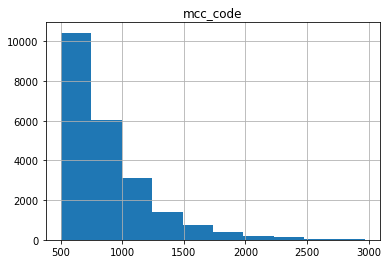

In [16]:
stats = transactions.groupby(by='user_id').mcc_code.count().to_frame()
print(stats.min(), stats.max())
stats.hist()

In [12]:
grp = transactions.groupby(by='user_id')['mcc_code'].count()

In [13]:
grp.quantile(0.75)

1023.0

In [9]:
grp = clickstream.groupby(by='user_id')['cat_id'].count()

In [11]:
grp.quantile(0.75)

7210.5

In [154]:
from dataset_utils import TargetBuilder

In [155]:
cls = TargetBuilder(train_matching)
df = cls.get_markup_df()
df.to_csv(path.join(data_dir, 'markup.csv'), index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132039/132039 [04:17<00:00, 512.18it/s]


In [162]:
transactions[transactions.user_id=='000932580e404dafbecd5916d4640938'].sort_values('transaction_dttm')

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.072300,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.313980,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.849810,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.476530,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.473700,2020-08-09 00:30:13
...,...,...,...,...,...
840,000932580e404dafbecd5916d4640938,5462,48,-130.767720,2021-07-30 01:44:14
841,000932580e404dafbecd5916d4640938,7999,48,-66.747345,2021-07-31 00:17:33
842,000932580e404dafbecd5916d4640938,4111,48,-23.074652,2021-07-31 01:06:32
843,000932580e404dafbecd5916d4640938,6011,48,-1059.120800,2021-07-31 01:11:50


In [166]:
mcc_codes[mcc_codes.MCC==6011]

,MCC,Название,Описание
263,6011,Финансовые учреждения – снятие наличных автома...,Используется для определения операций выдачи н...


In [167]:
from sklearn.preprocessing import LabelEncoder

In [191]:
le_mcc = LabelEncoder().fit([-1]+mcc_codes.MCC.sort_values().values.tolist())
le_currency_rk = LabelEncoder().fit([-1]+currency_rk.currency_rk.sort_values().values.tolist())
le_click_categories = LabelEncoder().fit(click_categories.cat_id.sort_values().values.tolist())

joblib.dump(le_mcc, path.join(data_dir, 'models_objects', 'le_mcc'))
joblib.dump(le_currency_rk, path.join(data_dir, 'models_objects', 'le_currency_rk'))
joblib.dump(le_click_categories, path.join(data_dir, 'models_objects', 'le_click_categories'))

['/home/ivan/Рабочий стол/vtb-matching/data/models_objects/le_click_categories']

In [224]:
# + 1 так как 0 будет паддинг
transactions.loc[:, ['transaction_dttm']] = pd.to_datetime(transactions.transaction_dttm)
transactions = transactions.sort_values('transaction_dttm')
transactions_grp = transactions.groupby('user_id') 
for user in tqdm_notebook(transactions_grp.groups):
    user_data = dict()
    user_slice = transactions_grp.get_group(user)
    user_data['user_id'] = user
    user_data['mcc_code'] = le_mcc.transform(user_slice.mcc_code) + 1
    user_data['currency_rk'] = le_currency_rk.transform(user_slice.currency_rk) + 1
    user_data['transaction_amt'] = user_slice.transaction_amt.values
    user_data['transaction_dttm'] = user_slice.transaction_dttm.values
    joblib.dump(user_data, path.join(data_dir, 'transaction_data', user))

  0%|          | 0/22533 [00:00<?, ?it/s]

In [221]:
clickstream.head(1)

,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448


In [225]:
# + 1 так как 0 будет паддинг
clickstream.loc[:, ['timestamp']] = pd.to_datetime(clickstream.timestamp)
clickstream = clickstream.sort_values('timestamp')
clickstream_grp = clickstream.groupby('user_id') 
for user in tqdm_notebook(clickstream_grp.groups):
    user_data = dict()
    user_slice = clickstream_grp.get_group(user)
    user_data['user_id'] = user
    user_data['cat_id'] = le_click_categories.transform(user_slice.cat_id) + 1
    user_data['timestamp'] = user_slice.timestamp.values
    user_data['new_uid'] = user_slice.new_uid.values
    joblib.dump(user_data, path.join(data_dir, 'clickstream_data', user))

  0%|          | 0/19623 [00:00<?, ?it/s]